# Motor de Insights para Planeamento Turístico Sustentável


## Sumário

1. Preparação de Dados e Engenharia de Features
2. Refinamento e Validação de Modelos
3. Implantação (simulação e salvamento)


## 1. Preparação de Dados e Engenharia de Features

Nesta fase vamos criar um conjunto de dados sintético que reflita as variáveis que identificámos na recolha teórica: fluxos de visitantes, ocupação hoteleira, receitas, empregos, indicadores de sustentabilidade, entre outros. Em seguida, vamos limpar os dados, criar novas variáveis (features) e explorar rapidamente a informação.

In [4]:
# Importações necessárias
import pandas as pd
import numpy as np

# Função para criar dados sintéticos por província e mês
def gerar_dados_sinteticos(start='2022-01-01', end='2024-12-31', provincias=None, seed=42):
    np.random.seed(seed)
    if provincias is None:
        provincias = ['Luanda', 'Benguela', 'Namibe', 'Huíla']
    meses = pd.date_range(start=start, end=end, freq='M')
    rows = []
    for prov in provincias:
        base_visitantes = {'Luanda':15000, 'Benguela':8000, 'Namibe':6000, 'Huíla':3000}[prov]
        seasonal_factor = {'Luanda':1.0, 'Benguela':0.9, 'Namibe':0.8, 'Huíla':0.7}[prov]
        for m in meses:
            month = m.month
            # Sazonalidade simples: pico em julho-agosto e dezembro
            saz = 1 + 0.25 * (1 if month in [7,8,12] else 0)
            visitantes = int(base_visitantes * saz * seasonal_factor * (0.9 + 0.2*np.random.rand()))
            ocupacao = max(10, min(95, np.random.normal(50 + 10*(saz-1), 8)))
            receita = visitantes * (np.random.normal(40000, 8000))  # Kz por visitante média
            empregos = int(visitantes * (0.02 + 0.005*np.random.rand()))  # proporção de empregos
            indice_sust = max(0, min(100, np.random.normal(70 - 5*(saz-1), 8)))
            temp = np.random.normal(25 - 3*(prov=='Huíla'), 2)  # Huíla um pouco mais frio
            satisfacao = max(0, min(10, np.random.normal(7 + 0.5*(saz-1), 1.2)))
            rows.append({
                'data': m,
                'provincia': prov,
                'visitantes_totais': visitantes,
                'ocupacao_hoteleira': round(ocupacao,2),
                'receita_turistica': round(receita,2),
                'empregos_gerados': empregos,
                'indice_sustentabilidade': round(indice_sust,1),
                'temperatura_media': round(temp,1),
                'satisfacao_turistica': round(satisfacao,2)
            })
    df = pd.DataFrame(rows)
    df = df.sort_values(['provincia','data']).reset_index(drop=True)
    return df

# Gerar os dados
df = gerar_dados_sinteticos()
df.head()

C:\Users\DAM\AppData\Local\Temp\ipykernel_3768\2641768952.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  meses = pd.date_range(start=start, end=end, freq='M')


,data,provincia,visitantes_totais,ocupacao_hoteleira,receita_turistica,empregos_gerados,indice_sustentabilidade,temperatura_media,satisfacao_turistica
0,2022-01-31,Benguela,6554,69.11,3.588139e+08,151,53.8,25.4,6.21
1,2022-02-28,Benguela,7112,56.82,2.405666e+08,148,83.3,24.1,6.22
2,2022-03-31,Benguela,7270,57.56,3.644542e+08,155,87.0,27.1,5.18
3,2022-04-30,Benguela,6992,46.13,2.664012e+08,143,85.0,18.5,5.77
4,2022-05-31,Benguela,6729,34.04,1.991680e+08,155,66.5,25.3,8.73


### Obs:

Os valores acima são sintéticos e foram gerados para demonstrar o pipeline. Como podem ver, **Benguela** se repete desde 0 até 4. Não é um erro de geração de dados, mas sim a forma como o **df.head()** funciona. Ele mostra apenas as primeiras 5 linhas do **DataFrame** e, por coincidência, como os dados são ordenados por provínvias antes de exibir, as primeiras 5 linhas pertencem à primeira província da lista, qe é **Benguela** na ordem alfabética ou conforme o loop.

### Exportação dos Dados Sintéticos

Após a criação do dataset fictício, os dados são guardados em formato `.csv` dentro da pasta
`data/raw/`, permitindo reprodutibilidade e uso futuro no modelo ou na interface web.

In [7]:
import os

# Criar diretório data/raw caso não exista
os.makedirs("../data/raw", exist_ok=True)

# Salvar o dataset gerado
df.to_csv("../data/raw/dados_brutos_demo.csv", index=False)
print("Dataset sintético salvo com sucesso em '../data/raw/dados_brutos_demo.csv'")


Dataset sintético salvo com sucesso em '../data/raw/dados_brutos_demo.csv'


### Limpeza de Dados

Agora vamos tratar problemas comuns: duplicados, tipos de dados e valores ausentes. Em bases reais podemos ter faltas e entradas inconsistentes; aqui mostramos técnicas simples para resolver isso.

In [9]:
# Limpeza simples
df = df.drop_duplicates().copy()
# Garantir tipos
df['data'] = pd.to_datetime(df['data'])
# Verificar nulos
print('Valores nulos por coluna:\n', df.isnull().sum())

# Introduzir intencionalmente alguns nulos para demonstrar imputação (apenas demo)
df.loc[df.sample(frac=0.01, random_state=1).index, 'ocupacao_hoteleira'] = np.nan
df.loc[df.sample(frac=0.01, random_state=2).index, 'receita_turistica'] = np.nan

# Imputar ocupacao com média por província e receita com interpolação temporal por província
df['ocupacao_hoteleira'] = df.groupby('provincia')['ocupacao_hoteleira'].transform(lambda x: x.fillna(x.mean()))
df['receita_turistica'] = df.groupby('provincia')['receita_turistica'].transform(lambda x: x.interpolate())

print('Após imputação, nulos:') 
print(df.isnull().sum())

Valores nulos por coluna:
 data                       0
provincia                  0
visitantes_totais          0
ocupacao_hoteleira         0
receita_turistica          0
empregos_gerados           0
indice_sustentabilidade    0
temperatura_media          0
satisfacao_turistica       0
dtype: int64
Após imputação, nulos:
data                       0
provincia                  0
visitantes_totais          0
ocupacao_hoteleira         0
receita_turistica          0
empregos_gerados           0
indice_sustentabilidade    0
temperatura_media          0
satisfacao_turistica       0
dtype: int64


### Att:

Valores ausentes e erros acontecem em dados reais. Se não tratarmos, os modelos podem falhar ou ter previsões erradas. Por isso aplicamos imputação simples e interpolação temporal quando faz sentido.

### Análise Exploratória (EDA)

Vamos ver algumas estatísticas e um gráfico simples para entender sazonalidade e distribuição por província.

In [12]:
# Estatísticas por província
display(df.groupby('provincia')[['visitantes_totais','receita_turistica','ocupacao_hoteleira']].describe().T)

# Série temporal agregada (exemplo): visitantes nacionais por mês
df_nacional = df.groupby('data')['visitantes_totais'].sum().reset_index()
df_nacional.head()

provincia                     Benguela         Huíla        Luanda  \
visitantes_totais  count  3.600000e+01  3.600000e+01  3.600000e+01   
                   mean   7.663833e+03  2.199083e+03  1.608889e+04   
                   std    1.019668e+03  2.753288e+02  1.658202e+03   
                   min    6.554000e+03  1.924000e+03  1.351500e+04   
                   25%    6.979000e+03  1.998000e+03  1.511900e+04   
                   50%    7.377500e+03  2.106500e+03  1.590300e+04   
                   75%    7.955750e+03  2.309500e+03  1.663050e+04   
                   max    9.831000e+03  2.815000e+03  2.027800e+04   
receita_turistica  count  3.600000e+01  3.600000e+01  3.600000e+01   
                   mean   2.970372e+08  8.657912e+07  6.603163e+08   
                   std    7.403040e+07  1.776655e+07  1.455656e+08   
                   min    1.801221e+08  5.009839e+07  4.090336e+08   
                   25%    2.446322e+08  7.538746e+07  5.392703e+08   
                   50%    2.932856e+08  8.798983e+07  6.426407e+08   
                   75%    3.437369e+08  9.703933e+07  7.609513e+08   
                   max    4.527544e+08  1.414018e+08  9.828285e+08   
ocupacao_hoteleira count  3.600000e+01  3.600000e+01  3.600000e+01   
                   mean   5.002694e+01  5.445806e+01  5.003457e+01   
                   std    8.713021e+00  7.847398e+00  9.692115e+00   
                   min    3.404000e+01  3.453000e+01  2.876000e+01   
                   25%    4.427250e+01  5.033000e+01  4.164750e+01   
                   50%    4.819000e+01  5.550000e+01  5.058000e+01   
                   75%    5.720000e+01  5.906500e+01  5.638000e+01   
                   max    6.911000e+01  6.755000e+01  7.698000e+01   

provincia                       Namibe  
visitantes_totais  count  3.600000e+01  
                   mean   4.962194e+03  
                   std    5.129488e+02  
                   min    4.355000e+03  
                   25%    4.592250e+03  
                   50%    4.787000e+03  
                   75%    5.267750e+03  
                   max    6.232000e+03  
receita_turistica  count  3.600000e+01  
                   mean   1.916915e+08  
                   std    4.955525e+07  
                   min    1.050480e+08  
                   25%    1.532432e+08  
                   50%    1.903208e+08  
                   75%    2.262592e+08  
                   max    2.912507e+08  
ocupacao_hoteleira count  3.600000e+01  
                   mean   5.186250e+01  
                   std    8.749483e+00  
                   min    3.248000e+01  
                   25%    4.596000e+01  
                   50%    5.003500e+01  
                   75%    5.742250e+01  
                   max    7.056000e+01

,data,visitantes_totais
0,2022-01-31,27854
1,2022-02-28,27930
2,2022-03-31,29159
3,2022-04-30,29305
4,2022-05-31,29026


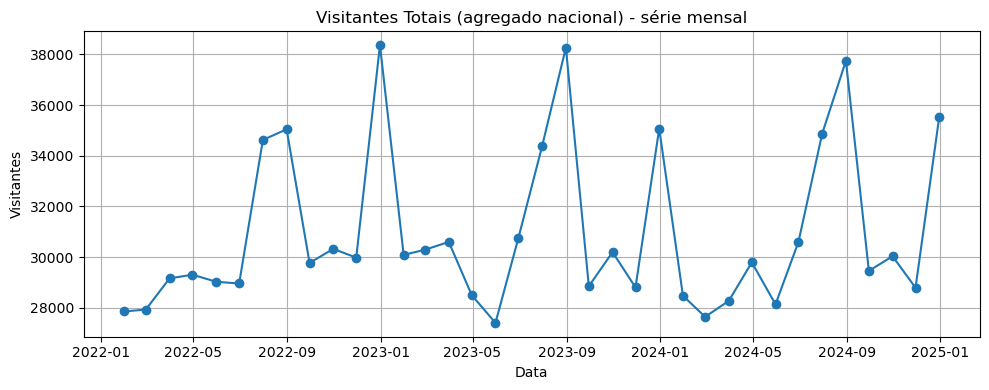

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(df_nacional['data'], df_nacional['visitantes_totais'], marker='o')
plt.title('Visitantes Totais (agregado nacional) - série mensal')
plt.xlabel('Data')
plt.ylabel('Visitantes')
plt.grid(True)
plt.tight_layout()
plt.show()

### Engenharia de Features

Vamos criar variáveis como receita per capita, taxa de variação (sazonalidade) e densidade relativa (simulada). Explico de forma simples o que cada uma faz no modelo.

In [15]:
# Engenharia de features
df['receita_per_capita'] = df['receita_turistica'] / df['visitantes_totais']
df['pct_var_visitantes_3m'] = df.groupby('provincia')['visitantes_totais'].pct_change(periods=3).fillna(0)
# Densidade turística relativa (simples): visitantes / (base populacional simulada)
pop_sim = {'Luanda':3000000, 'Benguela':800000, 'Namibe':400000, 'Huíla':500000}
df['densidade_turistica'] = df.apply(lambda r: r['visitantes_totais'] / pop_sim[r['provincia']], axis=1)

df[['data','provincia','visitantes_totais','receita_per_capita','pct_var_visitantes_3m','densidade_turistica']].head()

,data,provincia,visitantes_totais,receita_per_capita,pct_var_visitantes_3m,densidade_turistica
0,2022-01-31,Benguela,6554,54747.310067,0.000000,0.008193
1,2022-02-28,Benguela,7112,33825.447378,0.000000,0.008890
2,2022-03-31,Benguela,7270,50131.254843,0.000000,0.009088
3,2022-04-30,Benguela,6992,38100.864311,0.066829,0.008740
4,2022-05-31,Benguela,6729,29598.457267,-0.053853,0.008411


### Obs:

Criar features ajuda o modelo a 'entender' relações. Por exemplo, receita per capita relaciona dinheiro gasto com número de visitantes; a variação em 3 meses mostra tendência recente.

## 2. Refinamento e Validação de Modelos

Vamos escolher um caso prático para treino: previsão do número de visitantes por província. Para simplificar, treinaremos um RandomForest para prever `visitantes_totais` usando features que criámos. Também mostramos como preparar dados para modelos temporais como Prophet (quando disponível).

In [18]:
# Escolher província para exemplo de modelagem
prov_sel = 'Luanda'
df_model = df[df['provincia']==prov_sel].copy().reset_index(drop=True)

# Features e alvo
features = ['ocupacao_hoteleira','receita_per_capita','pct_var_visitantes_3m','densidade_turistica','indice_sustentabilidade','temperatura_media']
X = df_model[features].fillna(0)
y = df_model['visitantes_totais']

# Separar treino/teste (time-aware: usar últimos 20% como teste)
split_idx = int(len(df_model)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
print('Tamanhos -> treino:', X_train.shape, 'teste:', X_test.shape)

Tamanhos -> treino: (28, 6) teste: (8, 6)


In [19]:
# Treinar um RandomForest simples e rápido (explicação curta: modelo de conjunto que funciona bem)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

rf = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}')

MAE: 222.01, RMSE: 438.57, R2: 0.932


C:\Users\DAM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### ATT:

MAE e RMSE mostram erro em unidades de visitantes — quanto mais baixos, melhor. R² indica quanta variação foi explicada pelo modelo (1.0 é perfeito).

### Refinamento: procura simples de hiperparâmetros (GridSearch reduzido)

Para não demorar muito, faremos uma procura reduzida por `n_estimators` e `max_depth`.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {'n_estimators':[100,150,200],'max_depth':[8,12,16]}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print('Melhores params:', grid.best_params_)
best_rf = grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('MAE:', mean_absolute_error(y_test, y_pred_best))
print('RMSE:', mean_squared_error(y_test, y_pred_best, squared=False))
print('R2:', r2_score(y_test, y_pred_best))

Melhores params: {'max_depth': 8, 'n_estimators': 200}
MAE: 213.6968750000001
RMSE: 431.8631781775625
R2: 0.9338106780992


C:\Users\DAM\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Validação temporal para previsão (Prophet)

O Prophet é excelente para séries temporais. Aqui mostramos como preparar os dados para Prophet (se não estiver instalado, mostramos alternativa simples).

In [24]:
# Preparar série temporal para Prophet (exemplo)
df_ts = df_model[['data','visitantes_totais']].rename(columns={'data':'ds','visitantes_totais':'y'}).reset_index(drop=True)
df_ts.head()

,ds,y
0,2022-01-31,14623
1,2022-02-28,14045
2,2022-03-31,15335
3,2022-04-30,15277
4,2022-05-31,15552


In [25]:
# Tentar usar Prophet; se não estiver instalado, usar uma previsão simples (média + sazonalidade)
try:
    from prophet import Prophet
    use_prophet = True
except Exception as e:
    print('Prophet não disponível no ambiente. Iremos usar uma previsão simples como alternativa.')
    use_prophet = False

if use_prophet:
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(df_ts)
    future = m.make_future_dataframe(periods=6, freq='M')
    forecast = m.predict(future)
    display(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail())
else:
    # Alternativa simples: média dos últimos 12 meses + padrão sazonal mensal
    last12 = df_ts['y'].values[-12:]
    base = np.mean(last12)
    season = np.sin(np.linspace(0,2*np.pi,6)) * (np.std(last12)/4)
    approx_forecast = (base + season).round().astype(int)
    print('Previsão alternativa (próximos 6 meses):', approx_forecast.tolist())

Prophet não disponível no ambiente. Iremos usar uma previsão simples como alternativa.
Previsão alternativa (próximos 6 meses): [15848, 16273, 16111, 15586, 15424, 15848]


## 3. Implantação (serialização do modelo e testes de carregamento)

Agora vamos salvar o modelo treinado e mostrar como carregá-lo de novo. Isto é o que faríamos antes de integrar ao portal web (Streamlit) ou a uma API.

In [27]:
# Salvar o melhor modelo (joblib)
import joblib
joblib.dump(best_rf, 'modelo_random_forest_demo.pkl')
print('Modelo salvo em modelo_random_forest_demo.pkl')

Modelo salvo em modelo_random_forest_demo.pkl


In [28]:
# Testar carregamento e previsão rápida com o modelo salvo
loaded = joblib.load('modelo_random_forest_demo.pkl')
sample = X_test.iloc[-1:].values
print('Input de teste:', sample)
print('Predição carregada:', int(loaded.predict(sample)[0]))

Input de teste: [[6.12100000e+01 5.24830411e+04 8.93395279e-02 5.78366667e-03
  6.98000000e+01 2.35000000e+01]]
Predição carregada: 17493


C:\Users\DAM\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Obs:

Salvar o modelo permite que outro software (por exemplo, a app Streamlit) carregue o modelo e gere previsões sem treinar tudo de novo. Para produção, guardaríamos também o pipeline de transformação e controlaríamos versões.

## ATT:

Neste notebook montámos: criação de dados sintéticos coerentes com a recolha teórica, limpeza e engenharia de features, treino e refinamento de um RandomForest para previsão de visitantes, e a serialização do modelo para implantação. O estilo das explicações é direto e simples para facilitar o entendimento de um aprendiz.